In [1]:
%run ../spark-default.py

In [99]:
import builtins as b
from datetime import datetime, timedelta, date
import sys, traceback
from delta.tables import DeltaTable

from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel

In [3]:
df = spark.table("stage.ciha_step3")

df.printSchema()

root
 |-- pk: string (nullable = true)
 |-- mes_cmpt: string (nullable = true)
 |-- espec: string (nullable = true)
 |-- cgc_hosp: string (nullable = true)
 |-- munic_res: string (nullable = true)
 |-- nasc: date (nullable = true)
 |-- sexo: string (nullable = true)
 |-- uti_mes_to: string (nullable = true)
 |-- uti_int_to: string (nullable = true)
 |-- proc_rea: string (nullable = true)
 |-- qt_proc: string (nullable = true)
 |-- dt_atend: date (nullable = true)
 |-- dt_atend_dow: integer (nullable = true)
 |-- dt_saida: date (nullable = true)
 |-- diag_princ: string (nullable = true)
 |-- diag_secun: string (nullable = true)
 |-- cobranca: string (nullable = true)
 |-- natureza: string (nullable = true)
 |-- gestao: string (nullable = true)
 |-- munic_mov: string (nullable = true)
 |-- cod_idade: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- dias_perm: string (nullable = true)
 |-- morte: string (nullable = true)
 |-- nacional: string (nullable = true)
 |-- car_i

In [4]:
df.limit(5)

pk,mes_cmpt,espec,cgc_hosp,munic_res,nasc,sexo,uti_mes_to,uti_int_to,proc_rea,qt_proc,dt_atend,dt_atend_dow,dt_saida,diag_princ,diag_secun,cobranca,natureza,gestao,munic_mov,cod_idade,idade,dias_perm,morte,nacional,car_int,homonimo,cnes,fonte,cgc_consor,modalidade,input_file_name,arquivo_sigla_uf,ano_cmpt,feriado,feriados,feriados_prox,feriados_prox_dist,munic_res_nome_uf,munic_mov_nome_uf,munic_res_nome_municipio,munic_mov_nome_municipio,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_regiao,munic_mov_regiao,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,diag_princ_sub_categoria,diag_princ_sub_categoria_classificacao,diag_princ_restringido_sexo,diag_princ_causa_obito,diag_princ_sub_categoria_descricao,diag_princ_sub_categoria_descricao_abreviada,diag_princ_sub_categoria_referencia,diag_princ_sub_categoria_excluidos,diag_princ_categoria,diag_princ_categoria_classificacao,diag_princ_categoria_descricao,diag_princ_categoria_descricao_abreviada,diag_princ_categoria_referencia,diag_princ_capitulo_numero,diag_princ_capitulo_descricao,diag_princ_capitulo_descricao_abreviada,diag_secun_sub_categoria,diag_secun_sub_categoria_classificacao,diag_secun_restringido_sexo,diag_secun_causa_obito,diag_secun_sub_categoria_descricao,diag_secun_sub_categoria_descricao_abreviada,diag_secun_sub_categoria_referencia,diag_secun_sub_categoria_excluidos,diag_secun_categoria,diag_secun_categoria_classificacao,diag_secun_categoria_descricao,diag_secun_categoria_descricao_abreviada,diag_secun_categoria_referencia,diag_secun_capitulo_numero,diag_secun_capitulo_descricao,diag_secun_capitulo_descricao_abreviada,munic_res_idhm,munic_mov_idhm,proc_nome,proc_tp_complexidade,proc_tp_sexo,proc_qt_max_exec,proc_qt_dias_perm,proc_qt_pontos,proc_ds_procedimento,proc_no_grupo,proc_no_sub_grupo,proc_no_forma_organizacao
f8292abf-4df3-491...,06,null,60961422000155,355030,2019-04-08,3,0,000,0301010072,1,2024-06-20,5,2024-06-20,J039,null,18,null,M,355030,4,05,0,0,null,null,null,2089602,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-05-30, Cor...",19,São Paulo,São Paulo,São Paulo,São Paulo,SP,SP,Sudeste,Sudeste,11253503,11253503,1521.101,1521.101,J039,null,null,null,Amigdalite aguda ...,J03.9 Amigdalite ...,null,null,J03,null,Amigdalite aguda,J03 Amigdalite ...,null,10,Capítulo X - Doen...,X. Doenças do a...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.805,0.805,CONSULTA MEDICA E...,2,I,9999,9999,0000,CONSULTA CLÍNICA ...,Procedimentos clí...,Tratamentos clíni...,Tratamento de doe...
8ba519f8-620f-4bb...,11,null,44215341000150,350330,1973-02-15,3,0,000,0204030030,1,2024-11-11,2,2024-11-11,Z016,null,18,null,M,350330,4,51,0,0,null,null,null,2081253,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-11-20, Dia...",4,São Paulo,São Paulo,Araras,Araras,SP,SP,Sudeste,Sudeste,118843,118843,644.831,644.831,Z016,null,null,null,Exame radiológico...,Z01.6 Exame radio...,null,null,Z01,null,Outros exames e i...,Z01 Outr exam i...,null,21,Capítulo XXI - Fa...,XXI. Contatos com...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.781,0.781,MAMOGRAFIA,2,I,0002,9999,0000,EXAME RADIOLÓGICO...,Procedimentos com...,Diagnóstico em la...,Exames hematológi...
16f56e13-42bb-4c7...,04,null,16731630000176,310260,1946-03-07,3,0,000,0206010079,1,2024-04-28,1,2024-04-28,E889,null,18,null,M,310260,4,78,0,0,null,null,null,2775956,01,00000000000000,01,s3a://datalake/so...,MG,2024,false,null,"[{2024-05-01, Dia...",3,Minas Gerais,Minas Gerais,Andradas,Andradas,MG,MG,Sudeste,Sudeste,37270,37270,469.37,469.37,E889,null,null,null,Distúrbio metaból...,E88.9 Disturbio m...,null,null,E88,null,Outros distúrbios...,E88 Outr distur...,null,4,Capítulo IV - Doe...,IV. Doenças endó...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.734,0.734,TOMOGRAFIA COMPUT...,3,I,0002,9999,0000,CONSISTE NO MÉ

In [19]:
df_prep = df.filter(
    col("feriado").isNotNull()
    & col("uti_int_to").cast("integer").isNotNull()
    & col("diag_princ_categoria").isNotNull()
).select(
    col("dt_atend"),
    date_format("dt_atend", "dd").cast("integer").alias("dt_atend_dia"),
    date_format("dt_atend", "MM").cast("integer").alias("dt_atend_mes"),
    date_format("dt_atend", "yyyy").cast("integer").alias("dt_atend_ano"),
    weekofyear("dt_atend").alias("dt_atend_woy"),
    col("nasc"),
    date_format("nasc", "dd").cast("integer").alias("dt_nasc_dia"),
    date_format("nasc", "MM").cast("integer").alias("dt_nasc_mes"),
    date_format("nasc", "yyyy").cast("integer").alias("dt_nasc_ano"),
    weekofyear("nasc").alias("dt_nasc_woy"),
    col("sexo"),
    col("uti_int_to").cast("integer").alias("uti_int_to"),
    col("qt_proc").cast("integer").alias("qt_proc"),
    col("dt_atend_dow"), # 1 -> Domingo, 7 -> Sabado
    col("dt_saida"),
    date_format("dt_saida", "dd").cast("integer").alias("dt_saida_dia"),
    date_format("dt_saida", "MM").cast("integer").alias("dt_saida_mes"),
    date_format("dt_saida", "yyyy").cast("integer").alias("dt_saida_ano"),
    weekofyear("dt_saida").alias("dt_saida_woy"),
    col("diag_princ"),
    # col("diag_secun"),
    col("idade").cast("integer").alias("idade"),
    col("dias_perm").cast("integer").alias("dias_perm"),
    when(col("feriado") == lit(True), lit(1)).otherwise(lit(0)).alias("feriado"),
    size(col("feriados")).alias("feriados_qtd"),
    size(col("feriados_prox")).alias("feriados_prox_qtd"),
    when(col("feriados_prox_dist").isNull(), lit(30)).otherwise(col("feriados_prox_dist")).alias("feriados_prox_dist"),
    col("munic_res_sigla_uf"),
    col("munic_mov_sigla_uf"),
    col("munic_res_nome_uf"),
    col("munic_mov_nome_uf"),
    col("munic_res_populacao_residente").cast("integer").alias("munic_res_populacao_residente"),
    col("munic_mov_populacao_residente").cast("integer").alias("munic_mov_populacao_residente"),
    col("munic_res_area_unidade_territorial").cast("integer").alias("munic_res_area_unidade_territorial"),
    col("munic_mov_area_unidade_territorial").cast("integer").alias("munic_mov_area_unidade_territorial"),
    col("munic_res_idhm").cast("integer").alias("munic_res_idhm"),
    col("munic_mov_idhm").cast("integer").alias("munic_mov_idhm"),
    col("diag_princ_categoria"),
    # col("diag_secun_categoria"),
    col("diag_princ_capitulo_numero"),
    # col("diag_secun_capitulo_numero"),
    col("proc_rea"),
    # col("proc_tp_complexidade"),
    # col("proc_tp_sexo"),
    # col("proc_qt_max_exec").cast("integer").alias("proc_qt_max_exec"),
    # col("proc_qt_dias_perm").cast("integer").alias("proc_qt_dias_perm"),
    # col("proc_qt_pontos").cast("integer").alias("proc_qt_pontos"),
    # col("proc_no_grupo"),
    # col("proc_no_sub_grupo"),
    col("morte").cast("integer").alias("morte")
)

categorical_cols = [
    "sexo",
    "dt_atend_dow",
    "diag_princ",
    # "diag_secun",
    "munic_res_sigla_uf",
    "munic_mov_sigla_uf",
    "munic_res_nome_uf",
    "munic_mov_nome_uf",
    "feriado",
    "diag_princ_categoria",
    # "diag_secun_categoria",
    "diag_princ_capitulo_numero",
    # "diag_secun_capitulo_numero",
    "proc_rea",
    # "proc_tp_complexidade",
    # "proc_tp_sexo",
    # "proc_no_grupo",
    # "proc_no_sub_grupo",
    "dt_atend_mes",
    "dt_nasc_mes",
    "dt_saida_mes"
]

numeric_cols = [
    "dt_atend_dia",
    "dt_atend_ano",
    "dt_atend_woy",
    "dt_nasc_dia",
    "dt_nasc_ano",
    "dt_nasc_woy",
    "dt_saida_dia",
    "dt_saida_ano",
    "dt_saida_woy",
    "uti_int_to",
    "qt_proc",
    "idade",
    "dias_perm",
    "feriados_qtd",
    "feriados_prox_qtd",
    "feriados_prox_dist",
    "munic_res_populacao_residente",
    "munic_mov_populacao_residente",
    "munic_res_area_unidade_territorial",
    "munic_mov_area_unidade_territorial",
    "munic_res_idhm",
    "munic_mov_idhm",
    # "proc_qt_max_exec",
    # "proc_qt_dias_perm",
    # "proc_qt_pontos"
]

df_treinamento = df_prep.filter("dt_atend between '2011-01-01' and '2023-12-31'")
df_teste = df_prep.filter("dt_atend between '2024-01-01' and '2024-12-31'")

target_col = 'morte'

In [34]:
# Analise nulos

prep_nulls = df_prep.select(count("*").alias("total"), *[count(when(col(c).isNull(), c)).alias(c) for c in df_prep.columns]).first().asDict()

prep_nulls_total = prep_nulls["total"]

df_prep_nulls = spark.createDataFrame(
    [{"col": k, "count": v, "percentual": b.round((v/prep_nulls_total) * 100, 2)} for k,v in prep_nulls.items()]
) #.orderBy(col("count").desc())

df_prep_nulls.show(200, truncate=False)

+----------------------------------+---------+----------+
|col                               |count    |percentual|
+----------------------------------+---------+----------+
|total                             |124513800|100.0     |
|dt_atend                          |0        |0.0       |
|dt_atend_dia                      |0        |0.0       |
|dt_atend_mes                      |0        |0.0       |
|dt_atend_ano                      |0        |0.0       |
|dt_atend_woy                      |0        |0.0       |
|nasc                              |0        |0.0       |
|dt_nasc_dia                       |0        |0.0       |
|dt_nasc_mes                       |0        |0.0       |
|dt_nasc_ano                       |0        |0.0       |
|dt_nasc_woy                       |0        |0.0       |
|sexo                              |0        |0.0       |
|uti_int_to                        |0        |0.0       |
|qt_proc                           |0        |0.0       |
|dt_atend_dow 

In [7]:
print(df_prep.count())
print(df_treinamento.count())
print(df_teste.count())

124513800
112261227
10014182


In [53]:
# Tabela com vies alto, resolve com oversampling

# Na pratica deu bom, porem com uma razão de excesso de 23 (numero inexplicavel)

df_treinamento_m0 = df_treinamento.filter(df_treinamento.morte == 0)
df_treinamento_m1 = df_treinamento.filter(df_treinamento.morte == 1)

proporcao_mortes = df_treinamento_m0.count() / df_treinamento_m1.count()

df_treinamento_oversampled = df_treinamento_m1.sample(withReplacement=True, fraction=(proporcao_mortes))

df_treinamento_balanceado = df_treinamento_m0.union(df_treinamento_oversampled)

In [137]:
# Tabela com vies alto, resolve com peso

# Aconteceu a mesma coisa do oversampling, foi tratado com uma correção a partir da probabilidade que o modelo entregou

df_treinamento_m0 = df_treinamento.filter(df_treinamento.morte == 0)
df_treinamento_m1 = df_treinamento.filter(df_treinamento.morte == 1)

total = df_treinamento_m0.count() + df_treinamento_m1.count()
peso_morte = total / (2 * (df_treinamento_m1.count()))
peso_nao_morte = total / (2 * df_treinamento_m0.count())

df_treinamento_pesado = df_treinamento.withColumn("peso", when(col("morte") == 1, peso_morte/23).otherwise(peso_nao_morte/(1/23)))

print("Total:", total)
print("Peso morte:", peso_morte)
print("Peso nao morte:", peso_nao_morte)

Total: 112264091
Peso morte: 63.92035754467316
Peso nao morte: 0.5039419519169992


In [84]:
label_indexer = StringIndexer(inputCol=target_col, outputCol="label")

indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="skip") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in categorical_cols]

assembler_inputs = [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [85]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, weightCol="peso")

In [86]:
stages = [label_indexer] + indexers + encoders + [assembler, rf]
pipeline = Pipeline(stages=stages)

modelo_treinado = pipeline.fit(df_treinamento_pesado)

In [87]:
modelo_treinado.write().overwrite().save("s3a://datalake/models/classificacao_ciha_full/")

In [113]:
modelo_treinado = PipelineModel.load("s3a://datalake/models/classificacao_ciha_full/")

In [114]:
df_pred = modelo_treinado.transform(df_teste)

In [145]:
df_pred_corrigido = df_pred.select(
    col("dt_atend"),
    # col("prediction"),
    col("probability"),
    when(
        vector_to_array("probability")[1] > 0.555,
        lit(1.0)
    ).otherwise(0.0).alias("prediction"),
    col("morte")
).cache()

In [146]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

df_pred_ = df_pred_corrigido.withColumn("morte", col("morte").cast("integer").alias("morte"))

avaliador1 = MulticlassClassificationEvaluator(
    labelCol="morte",           # nome da coluna com a classe real
    predictionCol="prediction"  # nome da coluna com a predição
)

acuracia = avaliador1.setMetricName("accuracy").evaluate(df_pred_)
precisao = avaliador1.setMetricName("weightedPrecision").evaluate(df_pred_)
revocacao = avaliador1.setMetricName("weightedRecall").evaluate(df_pred_)
f1 = avaliador1.setMetricName("f1").evaluate(df_pred_)

avaliador2 = BinaryClassificationEvaluator(
    labelCol="morte",                 # nome da coluna com a classe real
    rawPredictionCol="probability",   # nome da coluna com a probabilidade
    metricName="areaUnderROC"
)

auc = avaliador2.evaluate(df_pred_)

print(f"Acurácia: {acuracia}")
print(f"Precisão Ponderada: {precisao}")
print(f"Revocação Ponderada: {revocacao}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

Acurácia: 0.9887819885213369
Precisão Ponderada: 0.9886528673063856
Revocação Ponderada: 0.9887819885213369
F1 Score: 0.9887172382866483
AUC: 0.8679793673587242


In [135]:
df_grafico = df_treinamento.select(
    col("dt_atend"),
    col("morte"),
    lit("treinamento").alias("dataset")
).union(
    df_pred_corrigido.select(
        col("dt_atend"),
        col("prediction").cast("integer").alias("morte"),
        lit("predict").alias("dataset")
    )
).union(
    df_teste.select(
        col("dt_atend"),
        col("morte"),
        lit("teste").alias("dataset")
    )
).withColumn("dt_atend_mes", date_format("dt_atend", "yyyy-MM")) \
 .groupBy(
    col("dt_atend_mes"),
    col("dataset")
 ).agg(
     sum("morte").alias("morte")
 ).cache()

df_grafico

dt_atend_mes,dataset,morte
2022-11,treinamento,5281
2022-02,treinamento,5898
2011-03,treinamento,4553
2015-07,treinamento,6416
2020-12,treinamento,6604
2021-11,treinamento,4896
2021-05,treinamento,8345
2021-10,treinamento,4965
2020-03,treinamento,5483
2019-04,treinamento,5591


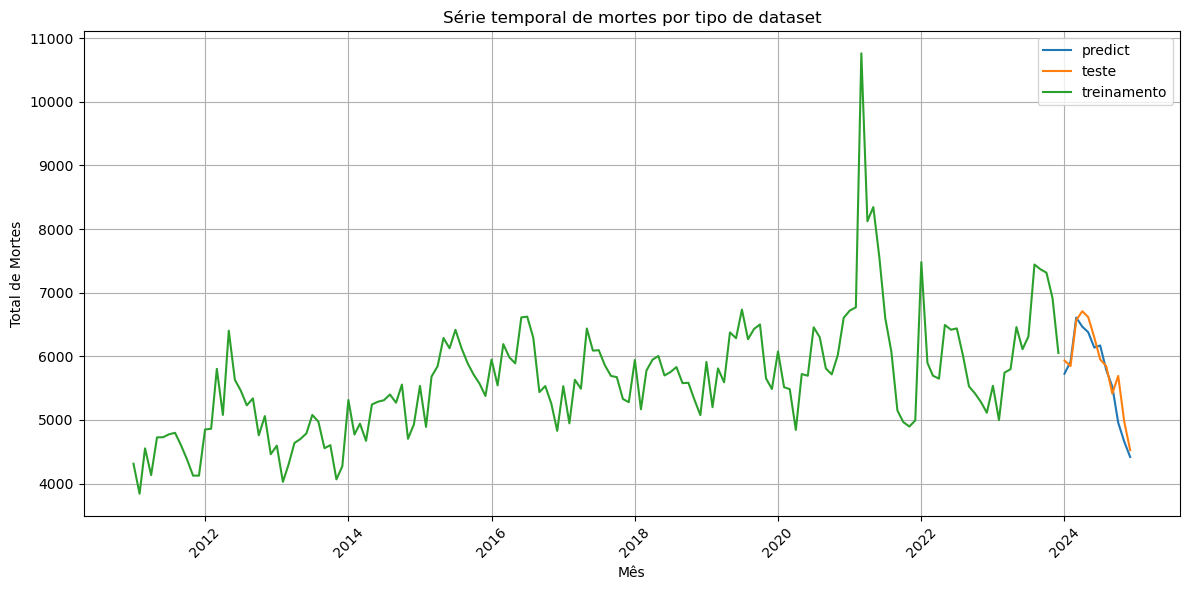

In [136]:
df_grafico_pd = df_grafico.toPandas()

df_grafico_pd['dt_atend_mes'] = pd.to_datetime(df_grafico_pd['dt_atend_mes'], format='%Y-%m')
df_grafico_pd = df_grafico_pd.sort_values('dt_atend_mes')
    
plt.figure(figsize=(12, 6))

for nome_dataset, grupo in df_grafico_pd.groupby("dataset"):
    if nome_dataset == "predict":
        plt.plot(grupo["dt_atend_mes"], grupo["morte"], label=nome_dataset)
    else:
        plt.plot(grupo["dt_atend_mes"], grupo["morte"], label=nome_dataset)

plt.xlabel("Mês")
plt.ylabel("Total de Mortes")
plt.title("Série temporal de mortes por tipo de dataset")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
spark.stop()